# Task 1 : Install Dependencies

In [2]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f2d05f6e36eb82d0c9aa5e92657ab09b50e0a482ad79a3d0f192f753dfe60d6e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=a472bfc57764c8b9c15e93a83203098804b38a9a0e5d4688e8c11eb61ece136b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
# !git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 35.35 MiB/s, done.
Resolving deltas: 100% (3/3), done.


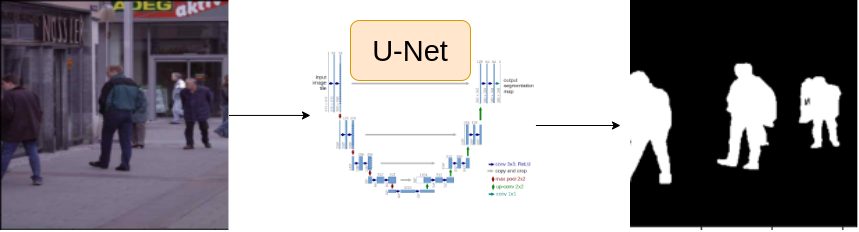

# Some Common Imports

In [2]:
import sys
sys.path.append(r'C:\Users\user2\Desktop\GitRepos\Human-Images-Segmentation\Human-Segmentation-Dataset-master')
print(sys.path)

['C:\\Users\\user2\\Desktop\\GitRepos\\Human-Images-Segmentation', 'C:\\Users\\user2\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'C:\\Users\\user2\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'C:\\Users\\user2\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'C:\\Users\\user2\\AppData\\Local\\Programs\\Python\\Python311', 'D:\\NLP 1\\venv', '', 'D:\\NLP 1\\venv\\Lib\\site-packages', 'D:\\NLP 1\\venv\\Lib\\site-packages\\llama_cpp_python-0.1.78-py3.11-win-amd64.egg', 'D:\\NLP 1\\venv\\Lib\\site-packages\\diskcache-5.6.1-py3.11.egg', 'D:\\NLP 1\\venv\\Lib\\site-packages\\win32', 'D:\\NLP 1\\venv\\Lib\\site-packages\\win32\\lib', 'D:\\NLP 1\\venv\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\user2\\Desktop\\GitRepos\\Human-Images-Segmentation\\Human-Segmentation-Dataset-master']


In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## TPU Settings

In [4]:
#TPU settings

# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

# import torch_xla
# import torch_xla.core.xla_model as xm

# import os
# assert os.environ['COLAB_TPU_ADDR']

# DEVICE = xm.xla_device()   #DEVICE code blo

# Task : 2 Setup Configurations

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [572]:
CSV_FILE = r'C:\Users\user2\Desktop\GitRepos\Human-Images-Segmentation\Human-Segmentation-Dataset-master\train.csv'
DATA_DIR = r'C:\Users\user2\Desktop\GitRepos\Human-Images-Segmentation'


EPOCHS = 50
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

# ENCODER = 'timm-efficientnet-b0'
# ENCODER = 'resnet18'
ENCODER = 'efficientnet-b3'

WEIGHTS = 'imagenet'

In [539]:
df = pd.read_csv(CSV_FILE)
print("Dataframe size: ", df.shape[0])
df.head()

Dataframe size:  290


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [540]:
row = df.iloc[15]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

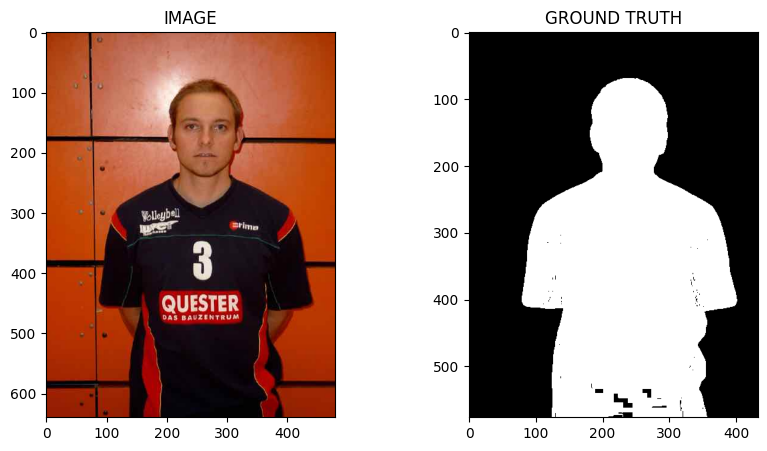

In [541]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [542]:
# I_added
anomaly_counter = 0
corrupted_idxs = []
for idx in range(df.shape[0]):
    image_size = cv2.imread(df.iloc[idx].images).shape
    mask_size = cv2.imread(df.iloc[idx].masks).shape
    if image_size != mask_size:
        anomaly_counter += 1
        corrupted_idxs.append(idx)
print(f"{anomaly_counter} number of masks don't match their corresponding images shape")

df.drop(corrupted_idxs, inplace=True)

print(f'corrupted data dropped out of dataframe, df now has {df.shape[0]} indices')
df

198 number of masks don't match their corresponding images shape
corrupted data dropped out of dataframe, df now has 92 indices


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
5,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
6,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
...,...,...
277,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
279,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
281,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
286,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [543]:
train_df, valid_df = train_test_split (df, test_size=0.1, random_state=42)

In [544]:
idx = 50
print(cv2.imread(df.iloc[idx].images).shape)
print(cv2.imread(df.iloc[idx].masks).shape)

(162, 311, 3)
(162, 311, 3)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [545]:
import albumentations as A

In [546]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ]
      ,is_check_shapes=False
  )

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [547]:
from torch.utils.data import Dataset

In [548]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w)
    mask = np.expand_dims(mask, axis = -1) #(h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image , mask = mask)
      image = data.get('image')
      mask = data.get('mask')

    #(h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    image.to(DEVICE) #I_added
    mask.to(DEVICE)  #I_added

    return image, mask

In [549]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [550]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 82
Size of Validset : 10


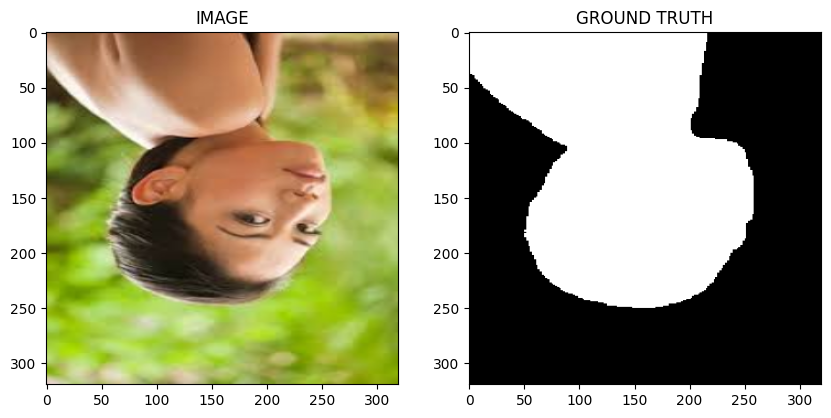

In [551]:
idx = 19

image, mask = trainset[idx]
helper.show_image(image, mask)

In [552]:
idx = 20
print(trainset[idx][0].shape)
print(trainset[idx][1].shape)

torch.Size([3, 320, 320])
torch.Size([1, 320, 320])


# Task 5 : Load dataset into batches

In [553]:
from torch.utils.data import DataLoader

In [554]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print("Total no. of batches in trainloader: ", len(trainloader))
print("Total no. of batches in validloader: ", len(validloader))

Total no. of batches in trainloader:  11
Total no. of batches in validloader:  2


In [555]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([8, 3, 320, 320])
One batch mask shape : torch.Size([8, 1, 320, 320])


# Task 6 : Create Segmentaion Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [560]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [564]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3,
        classes= 1,
        activation=None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [565]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to C:\Users\user2/.cache\torch\hub\checkpoints\efficientnet-b3-5fb5a3c3.pth
100%|█████████████████████████████████████████████████████████████████████████████| 47.1M/47.1M [00:35<00:00, 1.40MB/s]


In [566]:
model;

In [567]:
# I_added

# !pip install accelerate
# from accelerate import dispatch_model, infer_auto_device_map
# from accelerate.utils import get_balanced_memory

# max_memory = get_balanced_memory(
#     model,
#     max_memory=None,
#     no_split_module_classes=["GPTNeoXLayer", "GPTNeoXMLP"],
#     dtype='float16',
#     low_zero=False,
# )

# device_map = infer_auto_device_map(
#     model,
#     max_memory=max_memory,
#     no_split_module_classes=["GPTNeoXLayer", "GPTNeoXMLP"],
#     dtype='float16'
# )

# model = dispatch_model(model, device_map=device_map)

# Task 7 : Create Train and Validation Function

In [573]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()  #to use dropout and batch-norm
  total_loss = 0.0

  for images, mask in tqdm(data_loader):
    images = images.to(DEVICE)
    mask = mask.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, mask)
    loss.backward()   #gradinets computing
    optimizer.step()  #weights updating

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [574]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, mask in tqdm(data_loader):
      images = images.to(DEVICE)
      mask = mask.to(DEVICE)

      logits, loss = model(images, mask)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [575]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [576]:
best_valid_loss = np.Inf
train_loss_history = []
valid_loss_history = []

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  train_loss_history.append(train_loss)
  valid_loss_history.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("MODEL-SAVED")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1}    Train_loss: {train_loss}    Valid_loss: {valid_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


MODEL-SAVED
Epoch: 1    Train_loss: 0.34300418062643573    Valid_loss: 1.1229481101036072


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]


Epoch: 2    Train_loss: 0.31488748572089453    Valid_loss: 2.6980130672454834


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch: 3    Train_loss: 0.2681287052956494    Valid_loss: 3.601752758026123


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.47it/s]


Epoch: 4    Train_loss: 0.19445508312095294    Valid_loss: 1.800819754600525


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.01it/s]


Epoch: 5    Train_loss: 0.19305084713480689    Valid_loss: 1.4621325731277466


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]


Epoch: 6    Train_loss: 0.17658086595210162    Valid_loss: 10.110121250152588


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch: 7    Train_loss: 0.30175029080022464    Valid_loss: 1.2093122601509094


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]


MODEL-SAVED
Epoch: 8    Train_loss: 0.24049699171022934    Valid_loss: 0.480742409825325


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.21it/s]


Epoch: 9    Train_loss: 0.20237752321091565    Valid_loss: 1.55104261636734


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]


Epoch: 10    Train_loss: 0.1727506172927943    Valid_loss: 0.8276666104793549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]


Epoch: 11    Train_loss: 0.20582652972503143    Valid_loss: 1.7143075466156006


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch: 12    Train_loss: 0.1583613468842073    Valid_loss: 2.170840263366699


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


Epoch: 13    Train_loss: 0.13666393811052496    Valid_loss: 0.864245742559433


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]


MODEL-SAVED
Epoch: 14    Train_loss: 0.14230145717209036    Valid_loss: 0.44540510326623917


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


MODEL-SAVED
Epoch: 15    Train_loss: 0.15582391145554456    Valid_loss: 0.3194957599043846


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.56it/s]


Epoch: 16    Train_loss: 0.25779597935351456    Valid_loss: 0.7446504533290863


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


Epoch: 17    Train_loss: 0.2211200865832242    Valid_loss: 0.6166670620441437


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]


Epoch: 18    Train_loss: 0.22339221157810904    Valid_loss: 0.7903592586517334


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]


Epoch: 19    Train_loss: 0.21345521103252063    Valid_loss: 0.5540872812271118


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch: 20    Train_loss: 0.1775364950299263    Valid_loss: 0.4924829453229904


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.38it/s]


MODEL-SAVED
Epoch: 21    Train_loss: 0.1936962685801766    Valid_loss: 0.28928469866514206


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]


Epoch: 22    Train_loss: 0.19033289023421027    Valid_loss: 0.7434448897838593


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch: 23    Train_loss: 0.16933679512955926    Valid_loss: 0.7035264074802399


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.51it/s]


Epoch: 24    Train_loss: 0.18639116056940772    Valid_loss: 1.237490028142929


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s]


Epoch: 25    Train_loss: 0.19107028638774698    Valid_loss: 1.499625563621521


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch: 26    Train_loss: 0.19084012440659784    Valid_loss: 1.5301060676574707


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s]


Epoch: 27    Train_loss: 0.19832127541303635    Valid_loss: 1.4838367104530334


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.55it/s]


Epoch: 28    Train_loss: 0.20412727445363998    Valid_loss: 3.7599942684173584


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch: 29    Train_loss: 0.13482313467697662    Valid_loss: 4.931276082992554


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


Epoch: 30    Train_loss: 0.1276713711294261    Valid_loss: 1.6398006677627563


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


Epoch: 31    Train_loss: 0.11275909773328087    Valid_loss: 0.40773721039295197


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch: 32    Train_loss: 0.1032075776972554    Valid_loss: 0.43306006491184235


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.31it/s]


Epoch: 33    Train_loss: 0.10342967137694359    Valid_loss: 0.3573963865637779


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch: 34    Train_loss: 0.12420495057647879    Valid_loss: 0.5375829339027405


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch: 35    Train_loss: 0.14483001692728562    Valid_loss: 0.4279702305793762


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]


Epoch: 36    Train_loss: 0.12414716184139252    Valid_loss: 0.46272799372673035


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch: 37    Train_loss: 0.11589040607213974    Valid_loss: 0.30075622349977493


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


Epoch: 38    Train_loss: 0.10221721638332713    Valid_loss: 0.6036588400602341


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]


Epoch: 39    Train_loss: 0.09815364466472105    Valid_loss: 0.3924141675233841


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.52it/s]


Epoch: 40    Train_loss: 0.09032409638166428    Valid_loss: 0.38687245547771454


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]


Epoch: 41    Train_loss: 0.09535710242661563    Valid_loss: 0.34551673382520676


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s]


MODEL-SAVED
Epoch: 42    Train_loss: 0.09071312743154439    Valid_loss: 0.21108689159154892


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch: 43    Train_loss: 0.08634962446310303    Valid_loss: 0.27176445722579956


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


Epoch: 44    Train_loss: 0.11265290596268394    Valid_loss: 0.23111321404576302


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch: 45    Train_loss: 0.3106920888478106    Valid_loss: 0.2515859641134739


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.55it/s]


Epoch: 46    Train_loss: 0.16820906441320072    Valid_loss: 0.31801947951316833


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch: 47    Train_loss: 0.1199625466357578    Valid_loss: 0.7072813212871552


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch: 48    Train_loss: 0.16839143227447162    Valid_loss: 0.6177308410406113


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


Epoch: 49    Train_loss: 0.10343495079062202    Valid_loss: 0.4341092109680176


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]


Epoch: 50    Train_loss: 0.13045038892464203    Valid_loss: 0.5941988527774811


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


Epoch: 51    Train_loss: 0.11153871024196799    Valid_loss: 0.6963762938976288


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch: 52    Train_loss: 0.08800666711547157    Valid_loss: 0.3590932786464691


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.52it/s]


MODEL-SAVED
Epoch: 53    Train_loss: 0.07549979808655652    Valid_loss: 0.20713938772678375


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]


MODEL-SAVED
Epoch: 54    Train_loss: 0.06780050017616966    Valid_loss: 0.18721932172775269


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s]


Epoch: 55    Train_loss: 0.07350733639164404    Valid_loss: 0.21842918545007706


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.56it/s]


Epoch: 56    Train_loss: 0.06550420956178145    Valid_loss: 0.22084211558103561


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.55it/s]


Epoch: 57    Train_loss: 0.06976517222144386    Valid_loss: 0.1998253148049116


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


Epoch: 58    Train_loss: 0.06481000273065134    Valid_loss: 0.19709692522883415


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]


MODEL-SAVED
Epoch: 59    Train_loss: 0.08293729173866185    Valid_loss: 0.1725323349237442


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.01it/s]


Epoch: 60    Train_loss: 0.08117010275071318    Valid_loss: 0.38951434195041656


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s]


Epoch: 61    Train_loss: 0.07504154674031517    Valid_loss: 0.32478195428848267


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.38it/s]


Epoch: 62    Train_loss: 0.06350925022905524    Valid_loss: 0.3117591291666031


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]


Epoch: 63    Train_loss: 0.059266730465672234    Valid_loss: 0.3554295301437378


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.77it/s]


Epoch: 64    Train_loss: 0.05608816038478504    Valid_loss: 0.34882448613643646


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch: 65    Train_loss: 0.056864449246363205    Valid_loss: 0.3550318479537964


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.07it/s]


Epoch: 66    Train_loss: 0.053256849673661316    Valid_loss: 0.2855033427476883


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]


MODEL-SAVED
Epoch: 67    Train_loss: 0.053706021132794296    Valid_loss: 0.1715327650308609


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.38it/s]


Epoch: 68    Train_loss: 0.0585232095962221    Valid_loss: 0.2216903641819954


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]


Epoch: 69    Train_loss: 0.057843859900127755    Valid_loss: 0.3117063492536545


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.07it/s]


Epoch: 70    Train_loss: 0.06510080566460436    Valid_loss: 0.3645344525575638


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


Epoch: 71    Train_loss: 0.07248434458266605    Valid_loss: 0.4848413020372391


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.07it/s]


Epoch: 72    Train_loss: 0.07286473939364607    Valid_loss: 0.5150782465934753


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]


Epoch: 73    Train_loss: 0.10479565642096779    Valid_loss: 0.9241509437561035


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.68it/s]


Epoch: 74    Train_loss: 0.10412119599905881    Valid_loss: 0.436305433511734


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


Epoch: 75    Train_loss: 0.10035358945077116    Valid_loss: 0.3459952473640442


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.92it/s]


Epoch: 76    Train_loss: 0.09466274522922256    Valid_loss: 0.3636644035577774


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch: 77    Train_loss: 0.06707003407857635    Valid_loss: 0.38109923899173737


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.82it/s]


Epoch: 78    Train_loss: 0.12841462140733545    Valid_loss: 0.42877374589443207


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.37it/s]


Epoch: 79    Train_loss: 0.2829067903486165    Valid_loss: 1.3438987731933594


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.19it/s]


Epoch: 80    Train_loss: 0.22162812609564175    Valid_loss: 0.9057533740997314


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:12<00:10,  2.02s/it]


KeyboardInterrupt: 

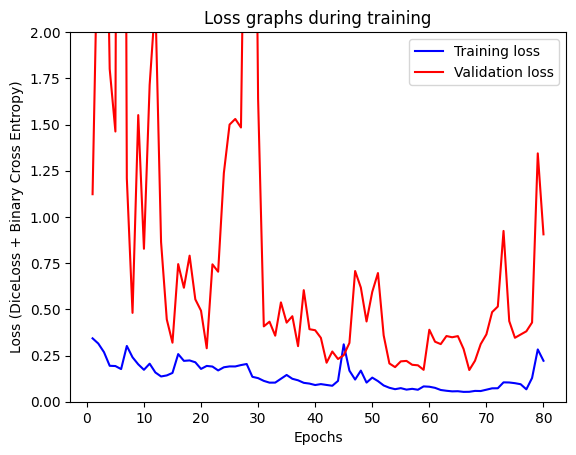

In [578]:
EPOCHS_passed = len(train_loss_history)
epochs = list(map(int, np.linspace(1,EPOCHS_passed, EPOCHS_passed)))
plt.plot(epochs, train_loss_history, 'b')
plt.plot(epochs, valid_loss_history, 'r')
plt.ylim(0, 2)

plt.title("Loss graphs during training")
plt.xlabel("Epochs")
plt.ylabel("Loss (DiceLoss + Binary Cross Entropy)")
plt.legend(['Training loss', 'Validation loss'])

plt.show()

# Task 9 : Inference

In [579]:
idx = 3

model.load_state_dict(torch.load(r"C:\Users\user2\Desktop\GitRepos\Human-Images-Segmentation\best_model.pt"))

image, mask = validset[idx]
# print(image.shape)
# print(type(image))
# print(image)

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) *1.0
# print(logits_mask)

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [581]:
def inference(image_path, model_path=r'best_model.pt', mask=None):
    def resize_image(image_path, height=320, width=320):
        image = Image.open(image_path)
        # image = Image.fromarray(np.uint8(image)).convert('RGB')
        MAX_SIZE = (width, height)
        image.thumbnail(MAX_SIZE)
        image = np.asarray(image)
        y_border = max(height - image.shape[0], 0)
        x_border = max(width - image.shape[1], 0)
        top = y_border // 2
        bottom = y_border - top
        left = x_border // 2
        right = x_border - left
        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT)
        return image
    image = resize_image(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    image = torch.Tensor(image) / 255.0
    model = SegmentationModel()
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) *1.0
    pred_mask = pred_mask.detach().cpu().squeeze(0)
    
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
    ax1.set_title('IMAGE')
    ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
    
    ax2.set_title('Overlay')
    ax2.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
    ax2.imshow(pred_mask.permute(1,2,0).squeeze(), cmap='gray', alpha=0.5)
    
    ax3.set_title('MODEL OUTPUT')
    ax3.imshow(pred_mask.permute(1,2,0).squeeze(),cmap = 'gray')

In [ ]:
inference(image_path=r'Test_data\6.jpg')

In [ ]:
import os
test_data = os.listdir('Test_data')

for img in test_data:
    inference(image_path=fr'Test_data\{img}')